In [1]:
import os
#################################
# TOY FOR SANITY CHECK
#################################

import math

import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/home/campus/kilian.fatras@MAIL.MCGILL.CA/flow_matching/conditional-flow-matching-private/')
# ALEX REPLACE ABOVE LINE BY YOUR OWN 'pwd' command output

from torchcfm.utils import *
from torchcfm.models import *
from torchcfm.conditional_flow_matching import *

savedir = "models/mnist"
os.makedirs(savedir, exist_ok=True)

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 128
test_batch_size = 64
n_epochs = 60

trainset = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (0.5,))
                   ]))

train_loader = torch.utils.data.DataLoader(trainset,
    batch_size=batch_size, shuffle=True, drop_last=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [3]:
#################################
#            OT-CFM
#################################

sigma = 0.1
dim = 28*28
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)


In [4]:
for epoch in range(n_epochs):
    running_loss = 0.0
    print(epoch)
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        x0 = torch.randn(batch_size, 28*28)
        x1, _ = data
        x1 = x1.view(batch_size, 28*28)

        t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)

        vt = model(torch.cat([xt, t], dim=-1))
        loss = torch.mean((vt - ut) ** 2)

        loss.backward()
        optimizer.step()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [16]:
node = NeuralODE(
torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
)
with torch.no_grad():
    traj = node.trajectory(
        torch.randn(batch_size, 28*28),
        t_span=torch.linspace(0, 1, 101),
    )


print(traj.size())

torch.Size([101, 128, 784])


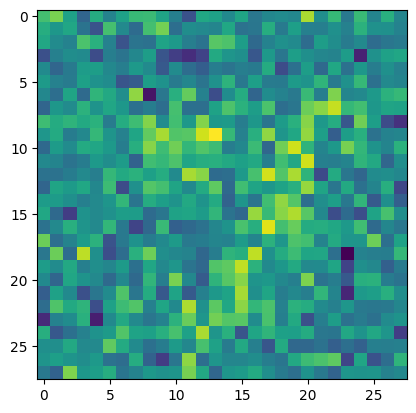

In [17]:
plt.imshow(traj[-1,-1].view(28,28,1))